# Demo: Processing and interpreting magnetic data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
xp, yp, zp, topo, data = np.loadtxt('mag-data.txt', unpack=True)
inc = -19.5
dec = -18.5

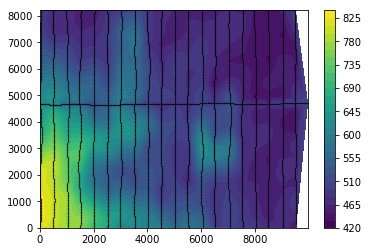

In [3]:
plt.tricontourf(yp, xp, -zp, 30)
plt.colorbar()
plt.plot(yp, xp, '.k', markersize=0.5)

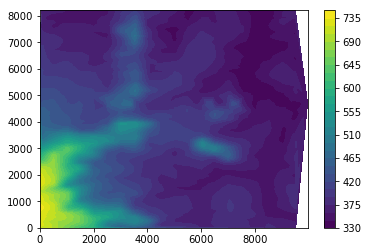

In [4]:
plt.tricontourf(yp, xp, topo, 30)
plt.colorbar()

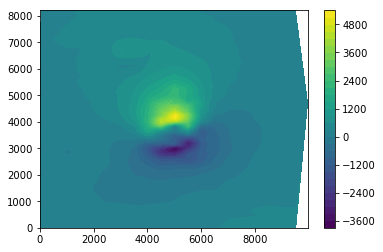

In [5]:
plt.tricontourf(yp, xp, data, 30)
plt.colorbar()

In [6]:
from fatiando.gravmag.eqlayer import EQLTotalField
from fatiando.inversion import Damping
from fatiando.mesher import PointGrid

/home/leo/bin/anaconda/envs/tgif-demo/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [7]:
area = [xp.min(), xp.max(), yp.min(), yp.max()]
layer = PointGrid(area, z=-100, shape=(80, 80))

In [8]:
misfit = EQLTotalField(xp, yp, zp, data, inc, dec, layer)
regul = Damping(misfit.nparams)

In [9]:
eql = misfit + 1e-12*regul

In [10]:
%%time
eql.fit()

CPU times: user 24.8 s, sys: 948 ms, total: 25.7 s
Wall time: 15.3 s


In [11]:
eql.estimate_

array([  -767336.60865397,   1592588.36522874,   4896565.87784263, ...,
       -17092323.07653675, -15505185.856221  , -14534311.75866608])

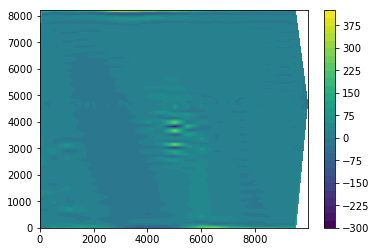

In [12]:
plt.tricontourf(yp, xp, eql[0].residuals(), 30)
plt.colorbar()

In [13]:
from fatiando import utils

In [14]:
layer.addprop('magnetization', utils.ang2vec(eql.estimate_, inc, dec))

In [15]:
from fatiando.gravmag import sphere
from fatiando import gridder

In [16]:
shape = (85, 85)
x, y, z = gridder.regular(area, shape=shape, z=-700)

In [17]:
tfa_grid = sphere.tf(x, y, z, layer, inc, dec)

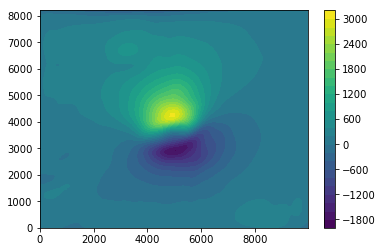

In [18]:
plt.tricontourf(y, x, tfa_grid, 30)
plt.colorbar()

In [19]:
from fatiando.gravmag import transform

In [20]:
tga = transform.tga(x, y, tfa_grid, shape)

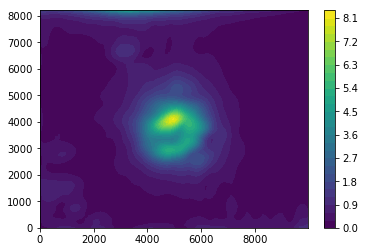

In [21]:
plt.tricontourf(y, x, tga, 30)
plt.colorbar()

In [22]:
pole = transform.reduce_to_pole(x, y, tfa_grid, shape, inc, dec, inc, dec)

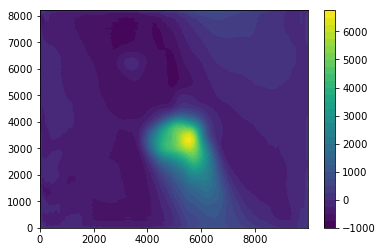

In [23]:
plt.tricontourf(y, x, pole, 30)
plt.colorbar()

In [24]:
from fatiando.gravmag.euler import EulerDeconvEW
from fatiando.gravmag.magdir import DipoleMagDir

In [25]:
dx = transform.derivx(x, y, tfa_grid, shape)
dy = transform.derivy(x, y, tfa_grid, shape)
dz = transform.derivz(x, y, tfa_grid, shape)

In [26]:
euler = EulerDeconvEW(x, y, z, tfa_grid, dx, dy, dz, structural_index=3, 
                      center=[4000, 5000], sizes=range(500, 8000, 500))

In [27]:
euler.fit()

In [28]:
euler.estimate_

array([ 3684.09587513,  5253.60075365,   627.67749843])

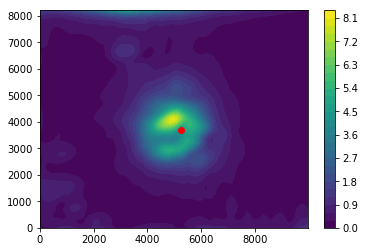

In [29]:
plt.tricontourf(y, x, tga, 30)
plt.colorbar()
plt.plot(euler.estimate_[1], euler.estimate_[0], 'ro')

In [30]:
mag = DipoleMagDir(x, y, z, tfa_grid, inc, dec, [euler.estimate_]).fit()

In [31]:
mag.estimate_

[[6908.4450952485677, -63.578688588810586, -39.964109312998175]]

In [32]:
inc, dec

(-19.5, -18.5)

In [33]:
sinc, sdec = mag.estimate_[0][1:]

In [34]:
pole = transform.reduce_to_pole(x, y, tfa_grid, shape, inc, dec, sinc, sdec)

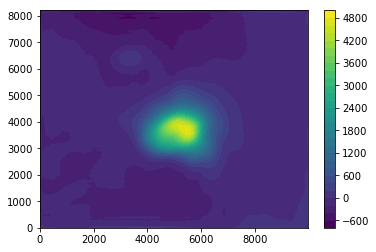

In [35]:
plt.tricontourf(y, x, pole, 30)
plt.colorbar()